### Working on the educational channel data

In [21]:
import pandas as pd
df_channel = pd.read_csv('edu-data/education_channel_with_country.csv')
df_channel_other = pd.read_csv('edu-data/other_channel_with_country.csv')
# df_video is large, it contains all educational data in YouNiverse
df_video = pd.read_csv('education_data._raw_yt_metadata.jsonl_no_description.csv')

### Now we check how many channels provide the nationality data 

In [35]:
import geopandas as gpd


shp_file_path = 'country-shp/world-administrative-boundaries.shp'
gdf_country = gpd.read_file(shp_file_path)
gdf_country = gdf_country.loc[:][['name','iso_3166_1_','geometry']]
gdf_country.columns = ['country_name','country','geometry']

In [23]:
df_channel = pd.merge(df_channel,gdf_country.loc[:][['country','country_name']],'left')

In [24]:
df_channel.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,country,country_name
0,Education,2015-06-29,UCltVEZ6GecWntoZ19FvaWhQ,Ekeeda,513000,6240,32492.0,IN,India
1,Education,2015-01-06,UCtJ9PC1Llj4f2DWPEz8utTA,Manchester Twp Schoo...,10300,102,920473.0,US,United States of America
2,Education,2010-04-20,UC9NTBQja_r2NI5e56PvuSAA,Daniel Kreuter,56700,250,253163.0,JP,Japan
3,Education,2015-01-30,UC4db8x07Kr0LQODjjen6w7A,Taylor Allard,14600,88,744777.0,US,United States of America
4,Education,2011-11-01,UCQFUt_0q3piEMaxJtOsz0fQ,Taylor Fuentes,48500,343,NaN,US,United States of America


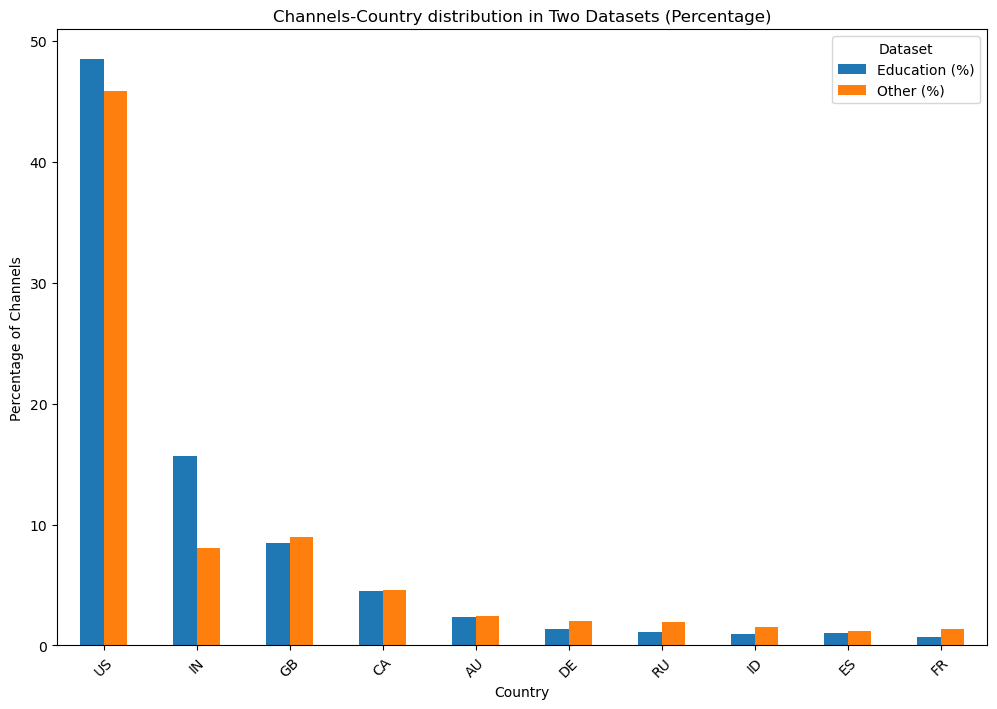

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

value_count = df_channel['country'].value_counts()
value_count_other = df_channel_other['country'].value_counts()


# Normalize each Series to get percentages
value_count_percent = (value_count / value_count.sum()) * 100
value_count_other_percent = (value_count_other / value_count_other.sum()) * 100

# Combine the two percentage Series into a DataFrame
df_combined_percent = pd.DataFrame({
    'Education (%)': value_count_percent,
    'Other (%)': value_count_other_percent
}).fillna(0)

# Select the top 10 countries based on total percentages in both datasets
top_countries_percent = df_combined_percent.sum(axis=1).nlargest(10).index
df_top_percent = df_combined_percent.loc[top_countries_percent]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
df_top_percent.plot(kind='bar', ax=ax)
plt.title('Channels-Country distribution in Two Datasets (Percentage)')
plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.show()

The US and most other countries show minimal differences in the distribution between education and other categories. However, India stands out with a notably higher proportion of education channels compared to other types.

### Join the video and the country data

In [28]:
df_channel = df_channel.rename(columns={'channel':'channel_id'})
df_video = pd.merge(df_video,df_channel.loc[:][['channel_id','name_cc','subscribers_cc','country']],on='channel_id',how = 'left')
df_video = df_video.drop(columns=['Unnamed: 0'])

In [29]:
df_video.to_csv('video_with_channelcountry.csv', index=False)

In [30]:
df_video.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,name_cc,subscribers_cc,country
0,Education,UCzztaOtjmaZoiLvWLagq7bg,2019-11-19 21:27:28.726568,11.0,zpWY6N1ow7o,573,428.0,"react,reaction,reactions,reacting,philippines,...",The Most Controversial Boxing World Champ | Fi...,2019-10-01 00:00:00,19558.0,Def Noodles,177000.0,US
1,Education,UCzztaOtjmaZoiLvWLagq7bg,2019-11-19 21:27:30.105280,296.0,Sh7whKR7UUw,445,1035.0,"react,reaction,reactions,reacting,reacts,phili...",This Man Was Hunted By Philippines Scout Range...,2019-09-29 00:00:00,47092.0,Def Noodles,177000.0,US
2,Education,UCzztaOtjmaZoiLvWLagq7bg,2019-11-19 21:27:31.365758,20.0,FMEzZOSqmBs,272,858.0,"react,reaction,reactions,reacting,reacts,phili...",Kavos Made Me Want To Quit YouTube,2019-09-27 00:00:00,10741.0,Def Noodles,177000.0,US
3,Education,UCzztaOtjmaZoiLvWLagq7bg,2019-11-19 21:27:36.129780,28.0,0ARnrLdTQOg,462,779.0,"react,reaction,reactions,reacting,reacts,phili...",Directed by Robert B. Weide Best MEMES Compila...,2019-09-22 00:00:00,20148.0,Def Noodles,177000.0,US
4,Education,UCzztaOtjmaZoiLvWLagq7bg,2019-11-19 21:27:37.753485,20.0,4xRAxG5Jtbg,1240,1005.0,"react,reaction,reactions,reacting,reacts,life ...",Kavos Roasted My Channel | My Response,2019-09-21 00:00:00,12777.0,Def Noodles,177000.0,US


In [31]:
import pandas as pd

df_video['upload_date'] = pd.to_datetime(df_video['upload_date'])
df_video['year'] = df_video['upload_date'].dt.year
df_video['tag_list'] = df_video['tags'].str.split(',')
df_exploded = df_video.explode('tag_list')
# need some time to run this 
tag_trends = df_exploded.groupby(['year', 'tag_list']).size().reset_index(name='count')
tag_trends_pivot = tag_trends.pivot(index='year', columns='tag_list', values='count').fillna(0)

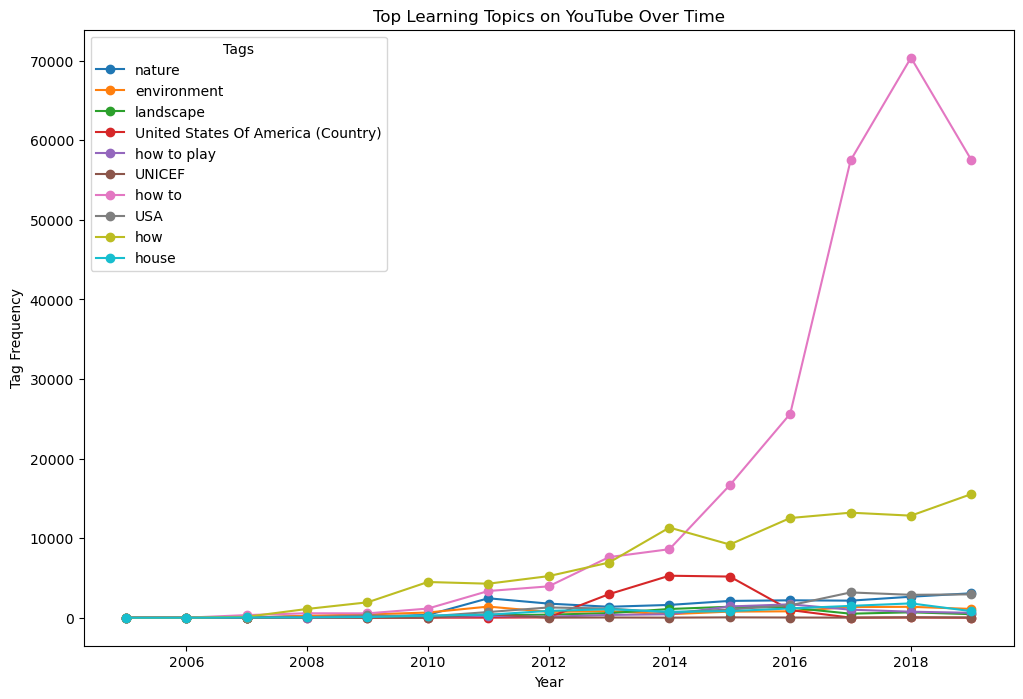

In [32]:
import matplotlib.pyplot as plt
top_tags = tag_trends['tag_list'].value_counts().head(10).index
tag_trends_top = tag_trends_pivot[top_tags]
plt.figure(figsize=(12, 8))
tag_trends_top.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Top Learning Topics on YouTube Over Time')
plt.xlabel('Year')
plt.ylabel('Tag Frequency')
plt.legend(title='Tags')
plt.show()

In [33]:
hot_tag_trends_pivot = tag_trends_pivot.loc[:, tag_trends_pivot.sum() > 1000]

In [34]:
hot_tag_trends_pivot

tag_list,#ACCTags,#AdobeCC,#Delhi,#EnglishLanguage,#FreedomFamily,#LearnEnglish,#MakeAdobeCC,#PCVERMA,#ProveAllThings,#Religión,...,인터넷방송,장난감,제시카,중국어,초급영어,초보영어,춤,한국말,한국어,（新）2012淨土大經科註
year,,,,,,,,,,,,,,,,,,,,,
2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,32.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181.0,182.0,1940.0
2013,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1060.0,1061.0,960.0


#### The Tags are very tricky to deal with
- the tags are in different language 
- many unrelated and redundant tags
- we need word2vec, fastText, or BERT to vectorize the tags and runs k-means or DBSCAN... to group the tags

#### so here we just analyze  programming languages because people usually don't translate them

In [73]:
programming_languages = [
    'Python', 'JavaScript', 'Java', 'C++', 'C#', 'C', 'SQL', 'Ruby', 
    'PHP', 'Swift', 'Kotlin', 'R', 'Go', 'MATLAB', 'Perl', 'Scala', 
    'Rust', 'TypeScript', 'Dart', 'Haskell', 'Objective-C', 'Shell', 
    'Lua', 'Groovy', 'COBOL', 'Fortran', 'SAS', 'Julia', 'VBScript', 
    'VBA', 'Solidity', 'PowerShell', 'Tcl'
]

In [75]:
df_video['tags'] = df_video['tags'].fillna('')

programming_languages = [lang.lower() for lang in programming_languages]
df_video['tag_list'] = df_video['tags'].str.lower().str.split(',')

df_programming = df_video[df_video['tag_list'].apply(lambda tags: any(lang in tags for lang in programming_languages))]

In [76]:
import pandas as pd

df_programming['year'] = df_programming['upload_date'].dt.year

df_programming_exploded = df_programming.explode('tag_list')
df_programming_exploded = df_programming_exploded[df_programming_exploded['tag_list'].isin(programming_languages)]

programming_trend = df_programming_exploded.groupby(['year', 'tag_list', 'country']).size().reset_index(name='count')

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_65416/3519535364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_programming['year'] = df_programming['upload_date'].dt.year


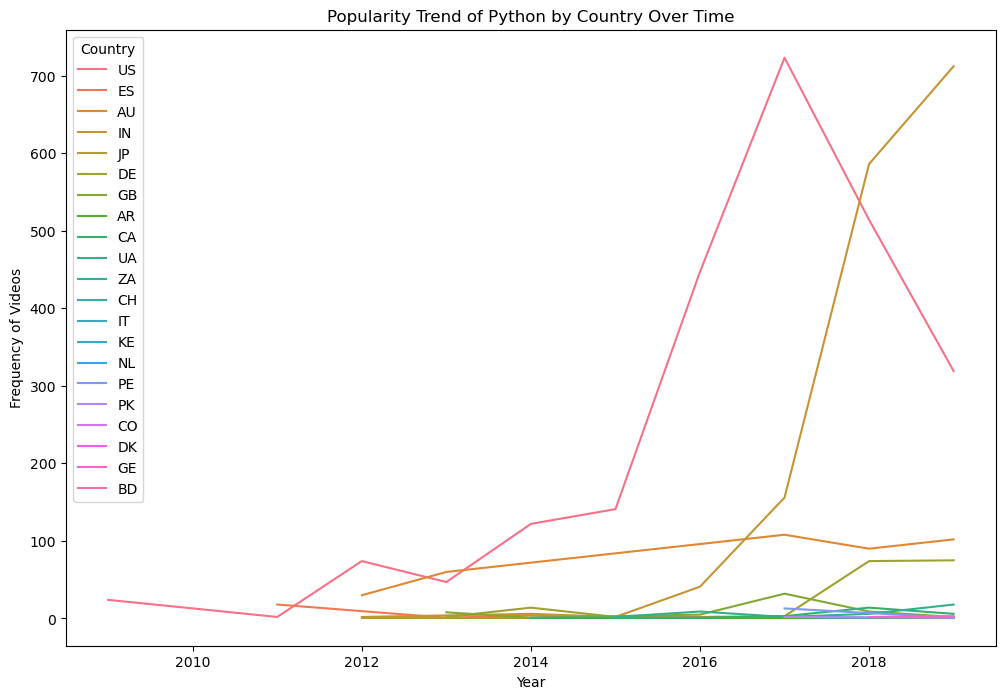

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns


language_to_plot = 'python'
df_language_trend = programming_trend[programming_trend['tag_list'] == language_to_plot]

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_language_trend, x='year', y='count', hue='country')
plt.title(f'Popularity Trend of {language_to_plot.title()} by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency of Videos')
plt.legend(title='Country')
plt.show()

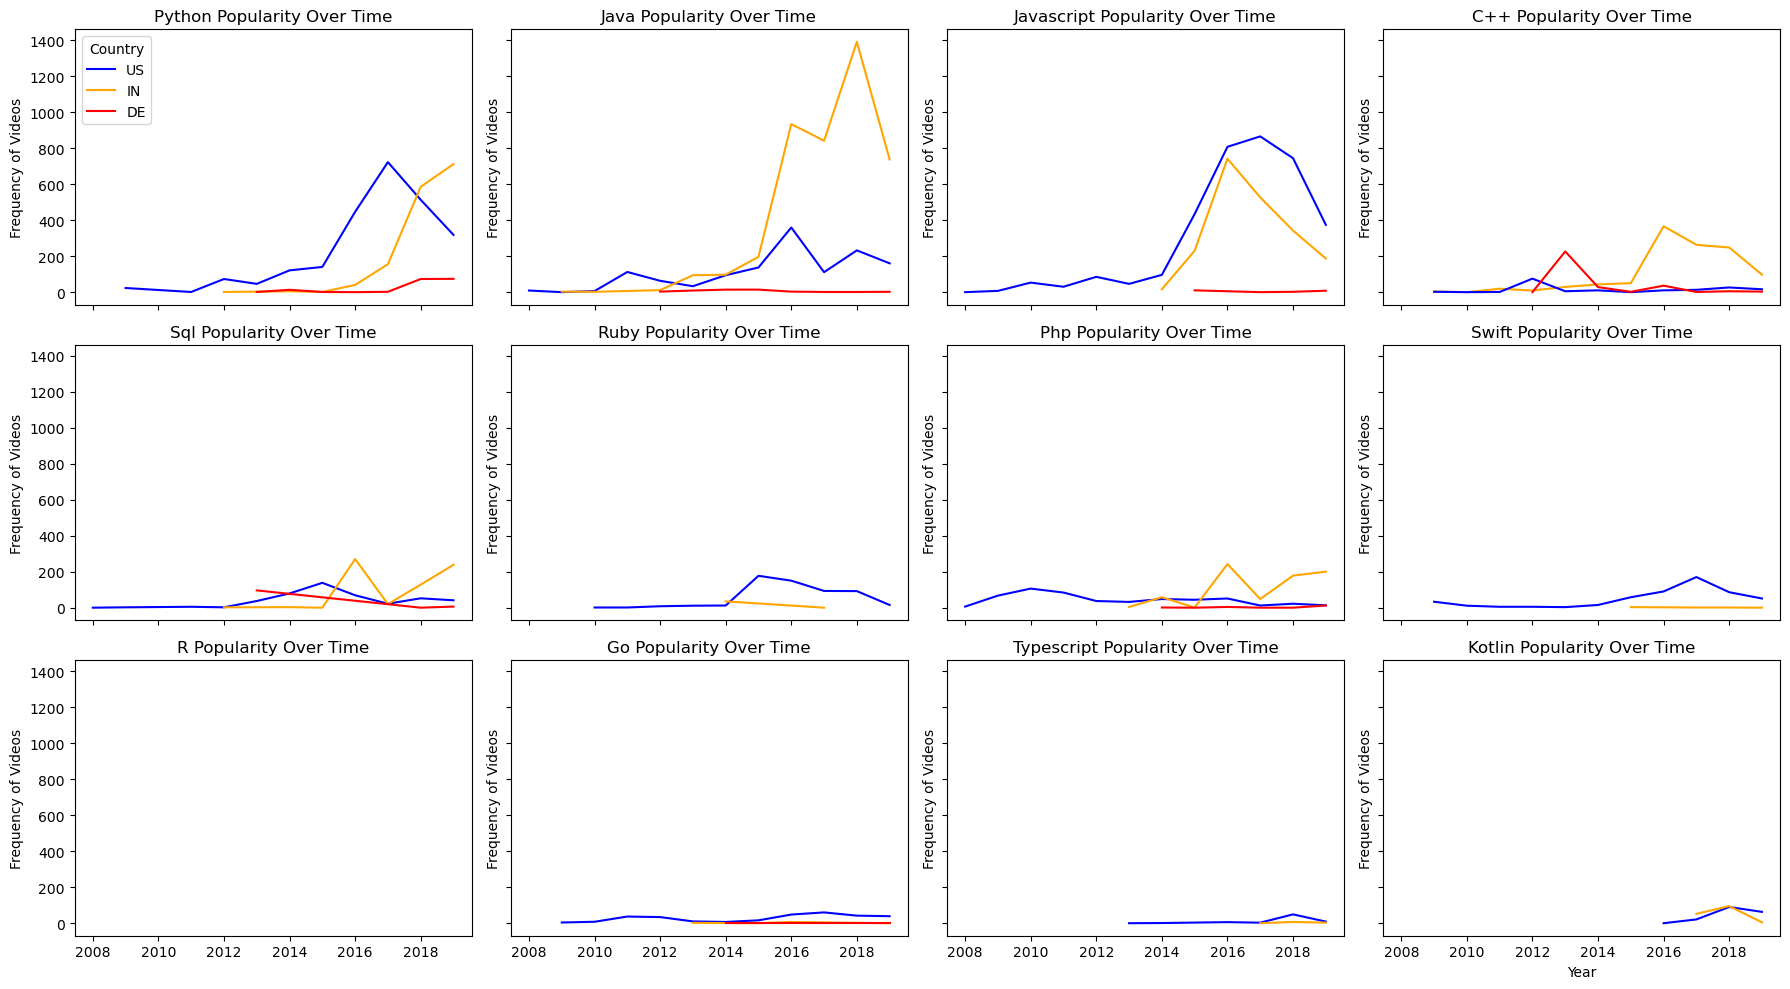

In [89]:
import matplotlib.pyplot as plt

countries_to_compare = ['US', 'IN','DE']
df_country_compare = programming_trend[programming_trend['country'].isin(countries_to_compare)]

languages_to_plot = ['python', 'java', 'javascript', 'c++', 'sql', 'ruby', 
                     'php', 'swift', 'r', 'go', 'typescript', 'kotlin']
num_languages = len(languages_to_plot)
n_rows = 3
n_cols = 4

# Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten() 

country_colors = {'US': 'blue', 'IN': 'orange','DE': 'red'}

for i, language in enumerate(languages_to_plot):
    ax = axes[i]
    df_language = df_country_compare[df_country_compare['tag_list'] == language]
    
    for country in df_language['country'].unique():
        country_data = df_language[df_language['country'] == country]
        ax.plot(country_data['year'], country_data['count'], label=country, color=country_colors[country])
    
    ax.set_title(f'{language.title()} Popularity Over Time')
    ax.set_ylabel('Frequency of Videos')
    
    # Only show the legend in the first subplot
    if i == 0:
        ax.legend(title='Country', loc='upper left')
    else:
        ax.legend().set_visible(False)

# Remove redundant subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel('Year')
plt.tight_layout()
plt.show()